#### En este notebook se puede visualizar la Fase 0: Cargue de datos y análisis visual de la red del proyecto en notebook o Gephi

El objetivo general del proyecto es analizar las redes sociales de diferentes inversionistas para caracterizar su
comportamiento e identificar los atributos significativos a la hora de financiar compañías. Se espera que los
estudiantes sean capaces de aplicar los conocimientos vistos en el curso en un contexto real y llevar a cabo
análisis e interpretaciones en el contexto del problema dado, utilizando las herramientas adecuadas. 

### Importar Librerias

In [11]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

### Importar base

In [12]:
# Importando archivos para ser limpiados y procesados
bi=pd.read_csv('Base-inicial.csv', sep=',')
nodos=pd.read_excel('Nodos.xlsx')
arcos=pd.read_excel('Arcos.xlsx')

### 1. Identificar la estructura de una base de datos para el análisis de redes.
Explorar datos 

In [13]:
bi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 34 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Organization Name                             2211 non-null   object 
 1   Headquarters Location                         2185 non-null   object 
 2   Operating Status                              2211 non-null   object 
 3   Company Type                                  1409 non-null   object 
 4   Number of Investments                         1494 non-null   float64
 5   Number of Lead Investments                    1348 non-null   float64
 6   Number of Diversity Investments               1059 non-null   float64
 7   Number of Exits                               1207 non-null   float64
 8   Number of Lead Investors                      1088 non-null   float64
 9   Number of Investors                           1195 non-null   f

In [14]:
nodos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2211 entries, 0 to 2210
Data columns (total 33 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   Id                                            2211 non-null   object        
 1   Headquarters Location                         2185 non-null   object        
 2   Operating Status                              2211 non-null   object        
 3   Company Type                                  1409 non-null   object        
 4   Number of Investments                         1494 non-null   float64       
 5   Number of Lead Investments                    1348 non-null   float64       
 6   Number of Diversity Investments               1059 non-null   float64       
 7   Number of Exits                               1207 non-null   float64       
 8   Number of Lead Investors                      1088 non-null   float6

In [15]:
arc=bi[["Principales inversionistas","Organization Name"]].reset_index(drop=True)
arc=arc.dropna()
arc["Principales inversionistas"]=arc["Principales inversionistas"].apply(lambda x: x.split(','))
Arcos=arc.explode("Principales inversionistas")
Arcos.rename(columns={"Principales inversionistas":"Source","Organization Name":"Target"},inplace=True)
Arcos.reset_index(drop=True, inplace=True)

In [16]:
for columna in arcos:
    indice_drop = arcos[arcos[columna].isin(nodos.Id) == False].index
    arcos.drop(index = indice_drop, inplace = True)


In [17]:
len(arcos)

4171

In [18]:
# Limpeza de set de datos
# Removiendo los puntos y comas en los campos identificados que contienen
nodos['SEMrush - Average Visits (6 months)'].replace('(\.\d+)',
                                                     '', regex=True, inplace=True)
nodos['SEMrush - Average Visits (6 months)'].replace('(,)',
                                                     '', regex=True, inplace=True)
nodos['SEMrush - Average Visits (6 months)'] = nodos['SEMrush - Average Visits (6 months)'].fillna(0)
nodos['SEMrush - Average Visits (6 months)'] = nodos['SEMrush - Average Visits (6 months)'].astype(float)
nodos['SEMrush - Monthly Visits'].replace('(\.\d+)',
                                          '', regex=True, inplace=True)
nodos['SEMrush - Monthly Visits'].replace('(,)', '', regex=True, inplace=True)
nodos['SEMrush - Monthly Visits'] = nodos['SEMrush - Monthly Visits'].fillna(0)
nodos['SEMrush - Monthly Visits'] = nodos['SEMrush - Monthly Visits'].astype(
    float)

# Imputando los valores nulos con 0, en las columnas timo float, int
columnas_num = nodos.loc[:, nodos.dtypes == np.float64].columns.tolist()
nodos[columnas_num] = nodos[columnas_num].fillna(0)
columnas_num = nodos.loc[:, nodos.dtypes == np.int64].columns.tolist()
nodos[columnas_num] = nodos[columnas_num].fillna(0)

# Imputando los valores nulos en las columnas tipo object con 'ND'
columnas_num = nodos.loc[:, nodos.dtypes == object].columns.tolist()
nodos[columnas_num] = nodos[columnas_num].fillna('ND')

# Imputando los valores nulos de las fechas con la media de las fechas
columnas_num = nodos.loc[:, nodos.dtypes == np.datetime64].columns.tolist()
nodos[columnas_num] = nodos[columnas_num].fillna(
    nodos['Last Funding Date'].median())

# Cambio de tipo de dato de float por int
columnas_num = nodos.loc[:, nodos.dtypes == np.float64].columns.tolist()
nodos[columnas_num] = nodos[columnas_num].astype(int)

# Creando columna de solo las ciudades, para enriquecer los datos en caso de que sea de utilidad en el analisis
nodos['Headquarters_city'] = [nodos["Headquarters Location"].apply(lambda x: str(x).split(
    ',')).values.tolist()[i][0] for i in range(len(nodos["Headquarters Location"]))]

# Creando columna Id en el set de datos de nodos, por los valores del indice de cada label
listan = [l for l, i in enumerate(nodos['Id'])]

# Cambiando el nombre de las empresas en el set de datos de arcos, para dejar target y source en terminos de Id de los nodos
nodes_dict = dict(zip(nodos['Id'].to_list(), listan))
source_cod = [nodes_dict[i] for i in arcos.Source]
target_cod = [nodes_dict[i] for i in arcos.Target]

# Creando las columnas en los set de datos de id, Source y Target
nodos['listan'] = listan
nodos.rename(columns={"Id": "label", "listan": "id"}, inplace=True)
arcos_id = arcos.copy()
arcos_id['source_cod'] = source_cod
arcos_id['target_cod'] = target_cod
arcos_id.drop(columns=['Source', 'Target'], axis=1, inplace=True)
arcos_id.rename(columns={"source_cod": "Source",
                "target_cod": "Target"}, inplace=True)

# Dejar Id de la compañía como índice de Nodos
nodos.set_index('id', inplace=True)


c:\Users\Jelb7\OneDrive - Universidad de los Andes\MIAD\Analytics_social_network\Social_network\.venv\lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)


In [19]:
# Desplenago los archivos para ser usados en Gephi
nodos.to_excel("Nodos_limpio.xlsx") 
arcos.to_excel("Arcos_limpio.xlsx") 
arcos_id.to_excel("Arcos_id.xlsx") 

## 2. Reconocer y calcular medidas de centralidad y prestigio de redes sociales. 

In [20]:
# Construir el grafo
G=nx.DiGraph()

# Nodos
# Agregar los nodos por su identificador
G.add_nodes_from(nodos.index)
# Agregar los atributos de los nodos
# Primero recorrer los nodos que se agregaron a la red
for nodo in G.nodes:
    # En cada nodo recorremos los atributos de los nodos
    for atr in nodos:
        # Agregar cada atributo al nodo
        G.nodes[nodo][atr]=nodos[atr][nodo]
        
# Arcos
# Agregar los arcos
G.add_edges_from([tuple(x) for x in arcos_id[['Source','Target']].to_numpy()])

In [25]:
H = G.to_undirected()
Gcc = sorted(nx.connected_components(H), key=len, reverse=True)
G0 = H.subgraph(Gcc[0])


In [44]:
subgrafos=[len(i) for i in Gcc]
print(subgrafos, len(subgrafos))

[2133, 5, 4, 4, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 62


In [29]:
G.number_of_nodes(),G0.number_of_nodes()

(2211, 2133)

In [30]:
G.number_of_edges(),G0.number_of_edges()

(4171, 4151)

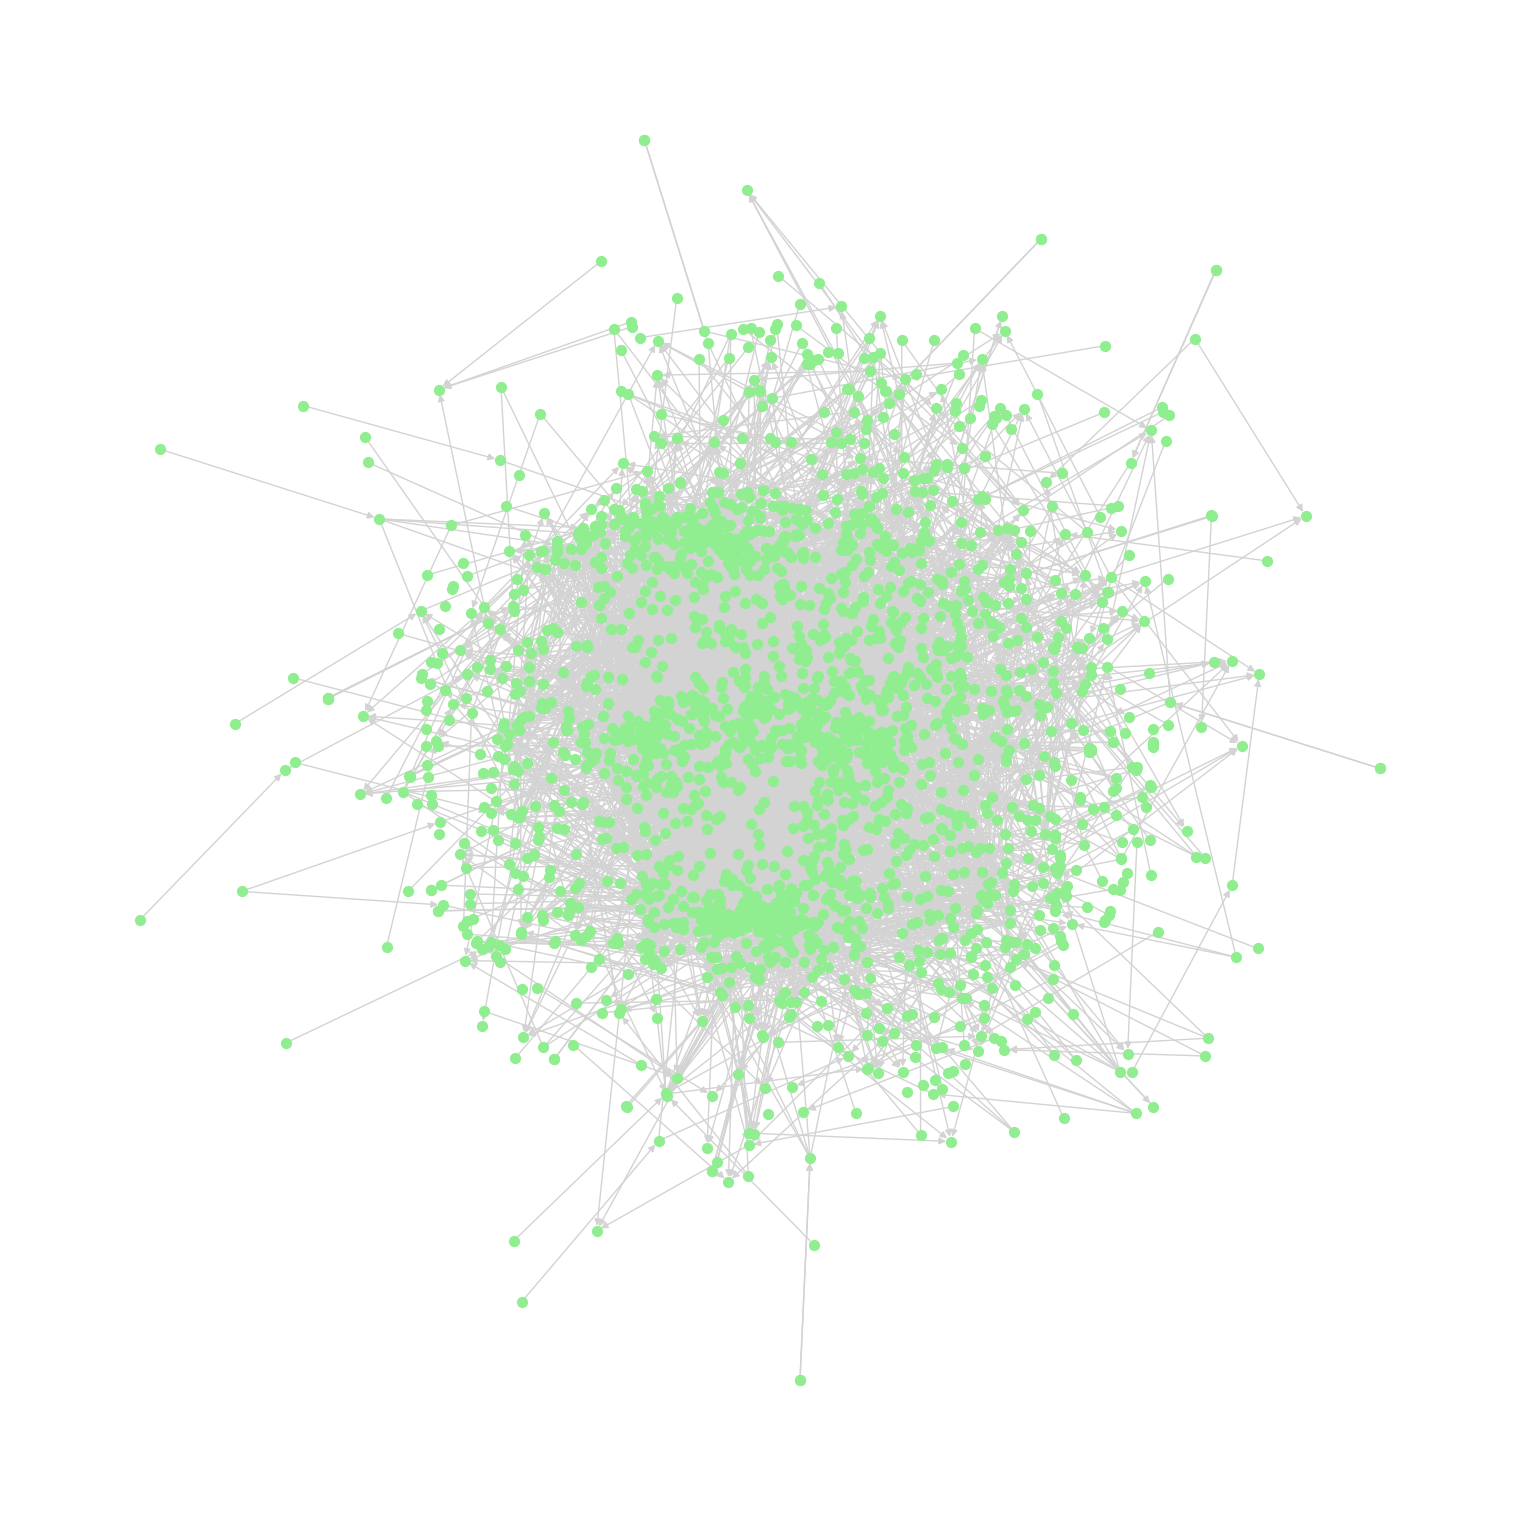

In [31]:
# Lienzo de la gráfica
fig=plt.figure(figsize=(15,15))

# Después se genera el gráfico
nx.draw_kamada_kawai(G, node_size=50, node_color='lightgreen', edge_color='lightgray')

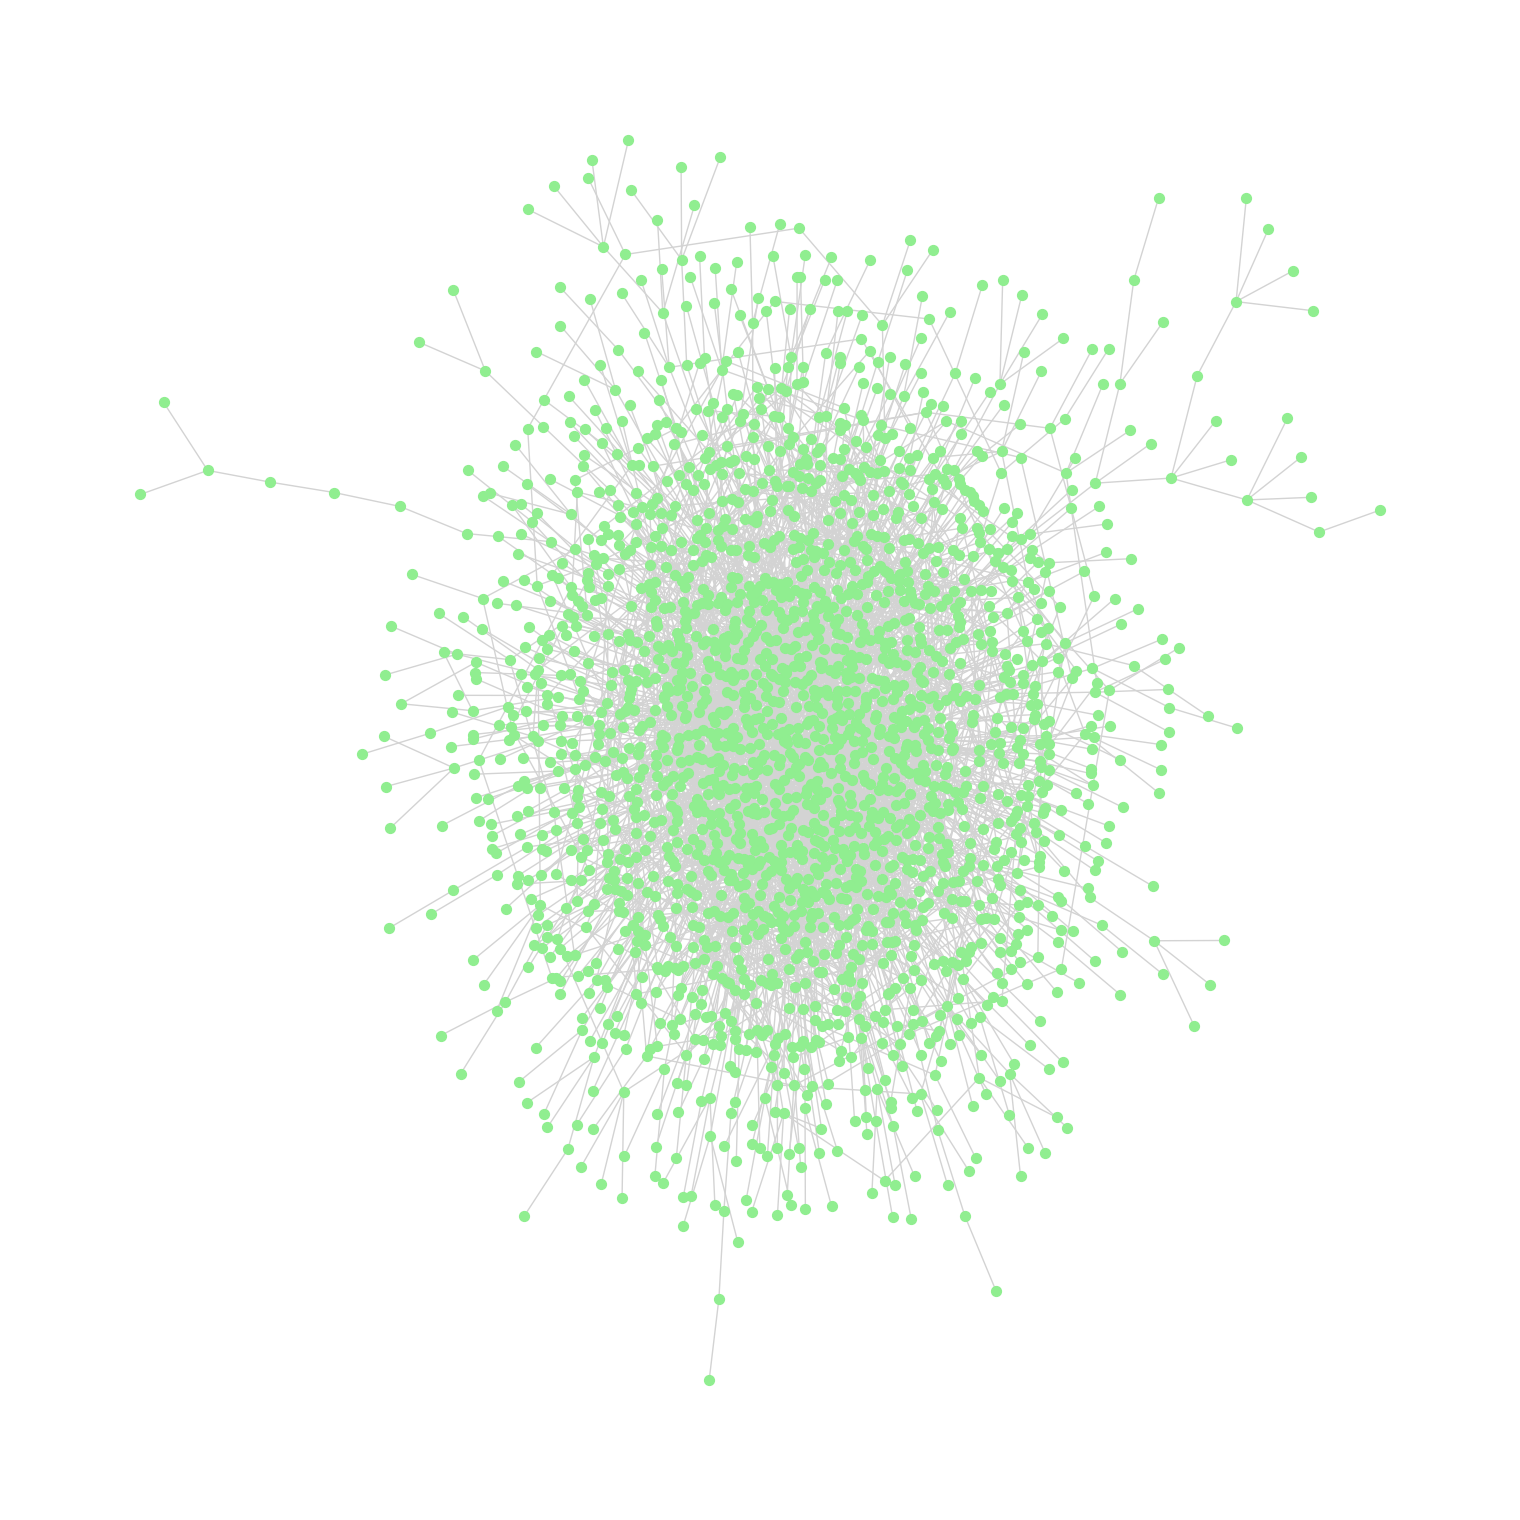

In [32]:
# Lienzo de la gráfica
fig=plt.figure(figsize=(15,15))

# Después se genera el gráfico
nx.draw_kamada_kawai(G0, node_size=50, node_color='lightgreen', edge_color='lightgray')

In [45]:
grados=G0.degree()

In [64]:
G0.nodes.data()[0]['label']

'Tencent'

In [46]:
# El nodo mas conectado
degrees=dict(grados)
max_v = max(zip(degrees.values(), degrees.keys()))
display(max_v)

(100, 255)

Int64Index([ 255, 1491,   67,  259, 1761,  894,    0,  261,  273, 1727,
            ...
            1197, 1198, 1200, 1201, 1202, 1204, 1206, 1209, 1212, 2210],
           dtype='int64', length=2133)

In [73]:
degrees=dict(grados)
degrees20=pd.DataFrame(data = degrees.values(), index = degrees.keys(), columns = ['degrees'])
degrees20.sort_values(by=['degrees'], inplace=True, ascending=False)
degrees20['label']=[G0.nodes.data()[i]['label'] for i in degrees20.index]
degrees20.head(15)


,degrees,label
255,100,Tiger Global Management
1491,81,Andreessen Horowitz
67,71,Sequoia Capital
259,69,Y Combinator
1761,65,Accel
894,63,Insight Partners
0,49,Tencent
261,46,Temasek Holdings
273,43,SoftBank Vision Fund
1727,42,Goldman Sachs


In [76]:
# Top 20 nodos con mayor closeness
between=dict(nx.closeness_centrality(G0))
between20=pd.DataFrame(data = between.values(), index = between.keys(), columns = ['betweenness'])
between20.sort_values(by=['betweenness'], inplace=True, ascending=False)
between20['label']=[G0.nodes.data()[i]['label'] for i in between20.index]
between20.head(15)

,betweenness,label
255,0.279460,Tiger Global Management
67,0.268785,Sequoia Capital
1491,0.268311,Andreessen Horowitz
894,0.264812,Insight Partners
1761,0.261307,Accel
273,0.260699,SoftBank Vision Fund
259,0.259304,Y Combinator
50,0.259147,SoftBank
261,0.259052,Temasek Holdings
1727,0.258612,Goldman Sachs


In [78]:
nx.eigenvector_centrality(G0)

#Nodo con mayor centralidad Eigenvector
eige=dict(nx.eigenvector_centrality(G0))
max_e = max(zip(eige.values(), eige.keys()))
max_e

(0.4119384014786925, 255)

In [79]:
eigen=dict(nx.eigenvector_centrality(G0))
eigen20=pd.DataFrame(data = eigen.values(), index = eigen.keys(), columns = ['eigenvector'])
eigen20.sort_values(by=['eigenvector'], inplace=True, ascending=False)
eigen20['label']=[G0.nodes.data()[i]['label'] for i in eigen20.index]
eigen20.head(15)

,eigenvector,label
255,0.411938,Tiger Global Management
1491,0.245862,Andreessen Horowitz
259,0.214454,Y Combinator
67,0.190864,Sequoia Capital
1761,0.189987,Accel
894,0.128404,Insight Partners
50,0.098877,SoftBank
261,0.095513,Temasek Holdings
901,0.093144,GV
295,0.086619,Sequoia Capital India


In [ ]:
betweenness=nx.betweenness_centrality(G)
max_b = max(zip(betweenness.values(), betweenness.keys()))
max_b

In [ ]:
# Top 20 nodos con mayor betweenness
between=dict(nx.betweenness_centrality(G))
between20=pd.DataFrame(data = between.values(), index = between.keys(), columns = ['betweenness'])
between20.sort_values(by=['betweenness'], inplace=True, ascending=False)
between20.head(20)

In [ ]:
closeness=nx.closeness_centrality(G)
max_c = max(zip(closeness.values(), closeness.keys()))
max_c

In [ ]:
# Top 20 nodos con mayor closeness
close=dict(nx.closeness_centrality(G))

close20=pd.DataFrame(data = close.values(), index = close.keys(), columns = ['Closeness'])
close20.sort_values(by=['Closeness'], inplace=True, ascending=False)
close20.head(20)


In [80]:
pagerank=nx.pagerank(G0)
max_p = max(zip(pagerank.values(), pagerank.keys()))
max_p

(0.00869262601745322, 255)

In [ ]:
# Importar el archivo pickle para utilizar la red
networokfile=open('Proyecto_SubGrafo.gpickle','rb')
G1=pickle.load(networokfile)
networokfile.close()

In [ ]:
clustering=nx.clustering(G)

#Calcular el clustering promedio
cluster=nx.clustering(G)
coef=list(cluster.values())
np.mean(coef)

### Medidas de la red

In [ ]:
#Distrucion del grado
grado=[]
for node in G.nodes():
    grado.append(G.degree(node))
    
a=plt.hist(grado)
plt.title('Histograma del grado de la red')
plt.xlabel ("Grado k")
plt.ylabel ("N(k)")
plt.show()

In [ ]:
## Diametro de la red
# Verificar que el grafo esté fuertemente conectado
nx.is_strongly_connected(G)

Ahora, como la red en la que se que se está trabajando es dirigida, significa que al seguir el sentido de los arcos no se puede llegar a todos los nodos, por lo que la red no esta fuertemente conectada. Para corregir esto y calcular el diametro podemos transformar la red en un no dirigida usando la función ``G.to_undirected()``, y guardando la red resultante en ``H``.

In [ ]:
# Convirtamos el grafo en uno no dirigido
H = G.to_undirected()

In [ ]:
# El grado está conectado
nx.is_connected(H)

### Densidad de la red

In [ ]:
# Función de NetworkX
densidad_red=nx.density(G)

### Reciprocidad de la red

In [ ]:
nx.reciprocity(G)

### Asortatividad de la red

In [ ]:
nx.degree_assortativity_coefficient(G)

In [ ]:
# Crear el lienzo para la red
fig=plt.figure(figsize=(150,150))

# Generar el gráfico
nx.draw(G, node_size=500, node_color='lightblue', edge_color='lightgray', with_labels=True)

In [ ]:

Operating_Status=[]
category=nx.get_node_attributes(G,'Operating Status')
for i in category.keys():
    if category[i] == 'Active':
        Operating_Status.append(i)

# Paso 2: Generar el subgrafo
ope = G.subgraph(Operating_Status)
nx.degree_assortativity_coefficient(ope)

In [ ]:
# Crear el lienzo para la red
fig=plt.figure(figsize=(50,50))

# Generar el gráfico
nx.draw(ope, node_size=500, node_color='lightblue', edge_color='lightgray', with_labels=True)

In [ ]:
Operating_Status=[]
category=nx.get_node_attributes(G,'Operating Status')
for i in category.keys():
    if category[i] == 'Closed':
        Operating_Status.append(i)

# Paso 2: Generar el subgrafo
ope = G.subgraph(Operating_Status)
# Generar el gráfico
nx.draw(ope, node_size=500, node_color='lightblue', edge_color='lightgray', with_labels=True)

In [ ]:
Operating_Status=[]
category=nx.get_node_attributes(G,'Company Type')
for i in category.keys():
    if category[i] == 'For Profit':
        Operating_Status.append(i)

# Paso 2: Generar el subgrafo
ope = G.subgraph(Operating_Status)

# Crear el lienzo para la red
fig=plt.figure(figsize=(50,50))
# Generar el gráfico
nx.draw(ope, node_size=500, node_color='lightblue', edge_color='lightgray', with_labels=True)

In [ ]:
industries=[]
category=nx.get_node_attributes(G,'Industry Groups')
for i in category.keys():
    if category[i] == 'Financial':
        industries.append(i)

# Paso 2: Generar el subgrafo
crypto = G.subgraph(industries)

# Crear el lienzo para la red
fig=plt.figure(figsize=(5,5))
# Generar el gráfico
nx.draw(crypto, node_size=500, node_color='lightblue', edge_color='lightgray', with_labels=True)

## 3. Interpretar los resultados de las medidas de centralidad y prestigio de redes sociales. 

## 4. Reconocer las características de los algoritmos de visualización de redes. 

## 5. Interpretar características de las redes a partir de su visualización.